<a href="https://colab.research.google.com/github/gourab337/Brownian-Motion-iHHO/blob/main/Mushroom_Classification_using_iHHO_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mushroom Classification using improved Harris Hawk Optimisation Algorithm**
Implementation of a novel control factor and Brownian motion-based improved Harris Hawk Optimisation for mushroom classification as part of Dr. Utkarsh Mahadeo Khaire's Optimization Techniques course at IIIT Dharwad (DS352)

**References:**

1. https://www.researchgate.net/publication/357750375_A_novel_control_factor_and_Brownian_motion-based_improved_Harris_Hawks_Optimization_for_feature_selection
2. [Implementation of Harris Hawks Optimization (HHO) Algorithm to Solve Engineering Problems](https://drive.google.com/file/d/1tC_87zvc7qZP53QAA-k9oQU4J6S_3BkH/view?usp=sharing)

**Code for original Harris Hawk Optimisation based on Levy Flight:** 
https://colab.research.google.com/drive/1rAA-XDewMAGn2I0JiSS1SX7E86fZPjZi?usp=sharing

**Important note:** Might encounter `TypeError: 'numpy.float128' object is not callable` in certain runtimes due to Google Colab's dependency architecture. To resolve the issue, execute the notebook in a new runtime (by reloading the site or creating a copy of the notebook and rexecuting. The later is done in order to resolve cache related issue.)

Libraries & imports:

In [ ]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score,mean_squared_error,log_loss
from tqdm import tqdm
import numpy as np
import random
import pickle as pkl
from tqdm import tqdm_notebook
import math
from math import pi,gamma,sin

import matplotlib.pyplot as plt

Taking dataset from Google Drive (public access) for easier usability:

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Dataset:

In [ ]:
link = "https://drive.google.com/file/d/1NBJylQ1hAuG4uJDsoHvUWpDH-P63iNHj/view?usp=sharing"
a,b = link.split('/d/')
id,d = b.split('/')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('mushrooms.csv')

dataset = pd.read_csv('mushrooms.csv')
y_train = dataset['class']
x_train = dataset.drop(labels =['class'],axis=1)
Bias =1
UB = np.max(x_train,axis=0)
LB = np.min(x_train,axis=0)
ohe = OneHotEncoder()
le = LabelEncoder()

cols = x_train.columns.values
for col in cols:
    x_train[col] = le.fit_transform(x_train[col])

y_train = le.fit_transform(y_train)

ohe = OneHotEncoder()
x_train = ohe.fit_transform(x_train).toarray()
sc = StandardScaler()
x_train = sc.fit_transform(x_train)


x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, test_size = 0.30, random_state = 42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test,y_test, test_size = 0.50, random_state = 42)

Displaying the dataset and some information on the dataset: 

In [ ]:
dataset.info(verbose=True)
print(dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

Artificial Neural Network Implementation: 

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

def relu(x):
    return np.maximum(0, x)

def forward(x, w, activation):
    return activation(np.matmul(x, w))

def accuracy_fn(y, y_hat):
    return (np.where(y == y_hat)[0].size / y_hat.size)

def predict(x, y_hat, weights, activation):
    predictions = np.zeros(shape=(x.shape[0]))
    
    for idx in range(x.shape[0]):
        r1 = x[idx, :]
        for curr_weights in weights:
            r1 = forward(r1, curr_weights, activation)
        predictions[idx] = np.where(r1 == np.max(r1))[0][0]

    accuracy = accuracy_fn(predictions, y_hat)
    return accuracy, predictions
    
def f(x, y_hat, weights, activation):
    accuracy = np.empty(shape=(weights.shape[0]))
    for idx in range(weights.shape[0]):
        accuracy[idx], _ = predict(x, y_hat, weights[idx, :], activation)
    return accuracy

Vector-Matrix Manipulations

In [ ]:
def mat_to_vector(mat_pop_weights):
    weights_vector = []
    for idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[idx, layer_idx], newshape=(mat_pop_weights[idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        weights_vector.append(curr_vector)
    return np.array(weights_vector)


def vector_to_mat(vector_weights, mat_pop_weights):
    mat_weights = []
    for idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[idx, layer_idx].size
            curr_vector = vector_weights[idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

Improved Harris Hawk Optimisation: 

In [ ]:
def HH(h1, h2):
    ub = np.uint32((h2*h1.shape[1]))
    lb = np.array(random.sample(range(0, h1.shape[1]), ub))
    
    for idx in range(h1.shape[0]):
        rand_Hawk = np.random.uniform(-1.0, 1.0, 1)
        h1[idx, lb] = h1[idx, lb] + rand_Hawk
    
    return h1

def error(m,n):
  Y_predF = []
  for k in range(0, m.shape[0]):
    perceptron = np.dot(m[k],n) + Bias
    sigmoid = 1.0/(1.0 + np.exp(-perceptron, dtype=np.float128))
    Y_predF.append(sigmoid)
  return log_loss(y_train,Y_predF)

def Levy(dim):
  beta=1.5
  sigma=(math.gamma(1+beta)*math.sin(math.pi*beta/2)/(math.gamma((1+beta)/2)*beta*2**((beta-1)/2)))**(1/beta) 
  U = 0.01*np.random.randn(dim)*sigma
  V = np.random.randn(dim)
  zz = np.power(np.absolute(V),(1/beta))
  step = np.divide(U,zz)
  return step

def levy(n1,Fitness,beta1):
    z = np.empty((beta1, n1.shape[1]))
    for sigma1 in range(beta1):
        num1 = np.where(Fitness == np.max(Fitness))
        num1 = num1[0][0]
        z[sigma1, :] = n1[num1, :]
        Fitness[num1] = -99
    return z

def Brown(V):
  step = 1/np.sqrt(2*np.pi)*np.exp(-V**2/2)
  return step

def classification(z, positions):
    u = np.empty(positions)
    v = np.uint32(positions[1]/2)

    for k in range(positions[0]):
        
        p1 = k%z.shape[0]
        p2 = (k+1)%z.shape[0]
        
        u[k, 0:v] = z[p1, 0:v]
        u[k, v:] = z[p2, v:]
        
    return u


Parameters: 

In [ ]:
dim = x_train.shape[1]  
Leader_pos = np.zeros(dim) 
Leader_score = math.inf
SearchAgents_no = 8
bias = 4
Max_iter = 100
h2 = 0.20
stepsize = np.zeros((SearchAgents_no,dim))
Convergence_curve = np.zeros(Max_iter)
Train_Accuracy = np.zeros(Max_iter)
Test_Accuracy = np.zeros(Max_iter)
ub = np.max(x_train,axis=0)
lb = np.min(x_train,axis=0)
Positions = np.zeros((SearchAgents_no,dim))
input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

Initial Weights: 

In [ ]:
initial_weights = []
for curr_sol in np.arange(0, SearchAgents_no):
    
    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
    w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
    w3 = np.random.uniform(low=-0.1, high=0.1,size=(64, output_shape))

    initial_weights.append(np.array([w1, w2, w3]))

In [ ]:
weights_mat = np.array(initial_weights)
weights_vector = mat_to_vector(weights_mat)

best_outputs = []
accuracies = np.empty(shape=(Max_iter))

Training:

In [ ]:
for t in tqdm(range(Max_iter)):

    # vector to matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)
    fit = f(x_train, y_train, weights_mat, activation=sigmoid)
    accuracies[t] = fit[0]
    z = levy(weights_vector, fit.copy(), bias)
    h1 = classification(z, positions=(weights_vector.shape[0]-z.shape[0], weights_vector.shape[1]))
    pos = HH(h1, h2=h2)
    weights_vector[0:z.shape[0], :] = z
    weights_vector[z.shape[0]:, :] = pos

100%|██████████| 100/100 [05:30<00:00,  3.30s/it]


In [ ]:
E1 = 2 * (1 - (t + 1) * 1.0 / Max_iter)       # factor to show the decreasing energy of rabbit
SearchAgents = 8
for i in tqdm(range(0, SearchAgents)):
  E0=2*random.random()-1  # -1<E0<1
  Escaping_Energy=E1*(E0)  # escaping energy of rabbit Eq. (3) in the paper

  # Escaping_Energy=E1  # New parameter 

  # -------- Exploration phase Eq. (1) in paper -------------------
  if abs(Escaping_Energy)>=1:
  # Harris' hawks perch randomly based on 2 strategy:
    q = random.random()
    rand_Hawk_index = math.floor(SearchAgents*random.random())
    X_rand = Positions[rand_Hawk_index, :]
    if q>=0.5:
    # perch based on other family members
      Positions[i,:]=X_rand-random.random()*abs(X_rand-2*random.random()*Positions[i,:])

    elif q<0.5:
          #perch on a random tall tree (random site inside group's home range)
          #Positions[i,:]=(Leader_pos - Positions.mean(0))-random.random()*((UB-LB)*random.random()+LB)
      Positions[i,:]=X_rand-random.random()*abs(X_rand-2*random.random()*Positions[i,:])

  # ----------Exploitation phase-------------------------------------
  elif abs(Escaping_Energy)<1:
          # Attacking the rabbit using 4 strategies regarding the behavior of the rabbit
          # phase 1: ----- surprise pounce (seven kills) ----------
          # surprise pounce (seven kills): multiple, short rapid dives by different hawks

    r=random.random() # probablity of each event
                
    if r>=0.5 and abs(Escaping_Energy)<0.5: # Hard besiege Eq. (6) in paper
            Positions[i,:]=(Leader_pos)-Escaping_Energy*abs(Leader_pos-Positions[i,:])

    if r>=0.5 and abs(Escaping_Energy)>=0.5:  # Soft besiege Eq. (4) in paper
            Jump_strength=2*(1- random.random()) # random jump strength of the rabbit
            Positions[i,:]=(Leader_pos-Positions[i,:])-Escaping_Energy*abs(Jump_strength*Leader_pos-Positions[i,:])

    if r<0.5 and abs(Escaping_Energy)>=0.5: # Soft besiege Eq. (10) in paper
            #rabbit try to escape by many zigzag deceptive motions
            Jump_strength=2*(1-random.random())
            X1=Leader_pos-Escaping_Energy*abs(Jump_strength*Leader_pos-Positions[i,:])

    else: # hawks perform levy-based short rapid dives around the rabbit
              # X2=X1+np.multiply(np.random.randn(dim),Levy(dim))
              # stepsize = np.multiply(Brown(X1),(Leader_pos-np.multiply(Brown(X1),Positions[i])))
              X2=Positions[i]+0.5*np.multiply(np.random.rand(Positions.shape[1]),stepsize)
              # X2=X1+np.multiply(np.random.randn(dim),Brown(dim))
              # X2 = numpy.clip(X2, lb, ub)
          
    if r<0.5 and abs(Escaping_Energy)<0.5:   # Hard besiege Eq. (11) in paper
            Jump_strength=2*(1-random.random())
            X1=Leader_pos-Escaping_Energy*abs(Jump_strength*Leader_pos-Positions.mean(0))

    else: # Perform levy-based short rapid dives around the rabbit
              # X2=X1+np.multiply(np.random.randn(dim),Levy(dim))
              # stepsize = np.multiply(Brown(X1),(Leader_pos-np.multiply(Brown(X1),Positions[i])))
              X2=Positions[i]+0.5*np.multiply(np.random.rand(Positions.shape[1]),stepsize)
              # X2=X1+np.multiply(np.random.randn(dim),Brown(dim))
              # X2 = np.clip(X2, lb, ub)
          
    for i in range(0, SearchAgents):
      Y_pred = []
      for j in range(0, x_train.shape[0]):
        perceptron = np.dot(x_train[j],Positions[i]) + Bias
        sigmoid = 1.0/(1.0 + np.exp(-perceptron, dtype=np.float128))
        Y_pred.append(sigmoid)
      fitness = log_loss(y_train,Y_pred)

  # Update the leader
      if fitness<Leader_score: # Change this to > for maximization problem
        Leader_score=fitness; # Update alpha
        Leader_pos=Positions[i,:].copy() # copy current whale position into the leader position

    Convergence_curve[t]= Leader_score

100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


In [ ]:
print(x_train,x_test,y_train,y_test,dataset)

[[-0.24272523 -0.02219484 -0.79620985 ... -0.40484176  4.59086996
  -0.15558197]
 [-0.24272523 -0.02219484 -0.79620985 ... -0.40484176 -0.21782364
  -0.15558197]
 [-0.24272523 -0.02219484 -0.79620985 ... -0.40484176 -0.21782364
  -0.15558197]
 ...
 [-0.24272523 -0.02219484  1.2559503  ...  2.47010093 -0.21782364
  -0.15558197]
 [-0.24272523 -0.02219484 -0.79620985 ...  2.47010093 -0.21782364
  -0.15558197]
 [-0.24272523 -0.02219484 -0.79620985 ... -0.40484176 -0.21782364
  -0.15558197]] [[-0.24272523 -0.02219484 -0.79620985 ... -0.40484176 -0.21782364
  -0.15558197]
 [-0.24272523 -0.02219484  1.2559503  ... -0.40484176 -0.21782364
  -0.15558197]
 [-0.24272523 -0.02219484 -0.79620985 ... -0.40484176 -0.21782364
  -0.15558197]
 ...
 [-0.24272523 -0.02219484  1.2559503  ...  2.47010093 -0.21782364
  -0.15558197]
 [-0.24272523 -0.02219484  1.2559503  ... -0.40484176 -0.21782364
  -0.15558197]
 [-0.24272523 -0.02219484 -0.79620985 ...  2.47010093 -0.21782364
  -0.15558197]] [1 0 1 ... 0 1 0

Analysis:

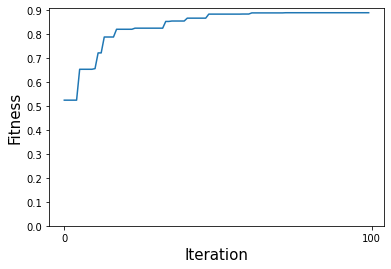

In [ ]:
plt.plot(accuracies)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.xticks(np.arange(0, Max_iter+1, 100))
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

Test predictions:

In [ ]:
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_test, y_test, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.8810500410172273
